# Food Analysis Project

This notebook is a small project where we analyze a food dataset consisting of commodity data pertaining to different countries, food markets, localities and the commodities found there

### Source : https://www.kaggle.com/datasets/jboysen/global-food-prices


Over 740k rows of prices obtained in developing world markets for various goods. Data includes information on country, market, price of good in local currency, quantity of good, and month recorded.

# Importing all dependencies

In [1]:
import chardet
import pandas as pd
import numpy as np
import csv
from forex_python.converter import CurrencyRates

# Importing and connecting Arkouda

In [2]:
import arkouda as ak

    _         _                   _       
   / \   _ __| | _____  _   _  __| | __ _ 
  / _ \ | '__| |/ / _ \| | | |/ _` |/ _` |
 / ___ \| |  |   < (_) | |_| | (_| | (_| |
/_/   \_\_|  |_|\_\___/ \__,_|\__,_|\__,_|
                                          

Client Version: v2021.10.07+3.g1e77539.dirty


In [3]:
ak.connect(connect_url='tcp://MacBook-Pro-7.local:5555 ') #connecting to arkouda server

/Users/narenkhatwani/Documents/GitHub/arkouda/arkouda/client.py:146: RuntimeWarning: Version mismatch between client (v2021.10.07+3.g1e77539.dirty) and server (v2021.08.20+18.g7a657ad); this may cause some commands to fail or behave incorrectly! Updating arkouda is strongly recommended.
  warnings.warn(('Version mismatch between client ({}) and server ({}); ' +
connected to arkouda server tcp://*:5555


# 1. Read the Data

In [4]:
#Printing the first few values from the DataSet
!head /Users/narenkhatwani/Desktop/Resources/CSV_files/wfp_market_food_prices.csv

adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_month,mp_year,mp_price,mp_commoditysource
1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,1,2014,50.0,WFP
1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,2,2014,50.0,WFP
1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,3,2014,50.0,WFP
1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,4,2014,50.0,WFP
1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,5,2014,50.0,WFP
1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,6,2014,50.0,WFP
1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,7,2014,50.0,WFP
1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,8,2014,50.0,WFP
1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,9,2014,50.0,WFP


In [5]:
#Checking the encoding of the csv file, resolved the partial encoding error
with open("/Users/narenkhatwani/Desktop/Resources/CSV_files/wfp_market_food_prices.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

## Column Name Descriptions
1. adm0_id: country id
2. adm0_name: country name
3. adm1_id: locality id
4. adm1_name: locality name
5. mkt_id: market id
6. mkt_name: market name
7. cm_id: commodity purchase id
8. cm_name: commodity purchased
9. cur_id: currency id
10. cur_name: name of currency
11. pt_id: market type id
12. pt_name: market type (Retail/Wholesale/Producer/Farm Gate)
13. um_id: measurement id
14. um_name: unit of goods measurement
15. mp_month: month recorded
16. mpyear: year recorded *mpprice: price paid
17. mp_commoditysource: Source supplying price information

In [6]:
#Reading the csv file and creating a dataframe
df=pd.read_csv("/Users/narenkhatwani/Desktop/Resources/CSV_files/utf8/wfpvam_foodprices_utf8.csv")

#displaying the top 5 rows for testing
df.head(5)

/Users/narenkhatwani/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_month,mp_year,mp_price,mp_commoditysource
0,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,1,2014,50.0,NaN
1,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,2,2014,50.0,NaN
2,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,3,2014,50.0,NaN
3,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,4,2014,50.0,NaN
4,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,5,2014,50.0,NaN


#### In order to read the csv stating a specific encoding we can use the encoding parameter

In [7]:
#df=pd.read_csv("/Users/narenkhatwani/Documents/GitHub/arkouda/Notebooks/Resources/wfp_market_food_prices_utf8.csv,encoding='ascii')

# 2. Cleaning the Data 

## 2.1 Convert the csv to hdf file using to_hdf method of Python (not recommended)

In [8]:
df2=pd.read_csv("/Users/narenkhatwani/Desktop/Resources/CSV_files/utf8/wfpvam_foodprices_utf8.csv")

df2.to_hdf("/Users/narenkhatwani/Desktop/Resources/CSV_files/to_hdf/Food_prices_hdf5.h5", 'data', mode='w', format='table')


/Users/narenkhatwani/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
print(pd.read_hdf('/Users/narenkhatwani/Desktop/Resources/CSV_files/to_hdf/Food_prices_hdf5.h5', 'data').head(5))

   adm0_id    adm0_name  adm1_id   adm1_name  mkt_id  mkt_name  cm_id  \
0        1  Afghanistan      272  Badakhshan     266  Fayzabad     55   
1        1  Afghanistan      272  Badakhshan     266  Fayzabad     55   
2        1  Afghanistan      272  Badakhshan     266  Fayzabad     55   
3        1  Afghanistan      272  Badakhshan     266  Fayzabad     55   
4        1  Afghanistan      272  Badakhshan     266  Fayzabad     55   

          cm_name  cur_id cur_name  pt_id pt_name  um_id um_name  mp_month  \
0  Bread - Retail       0      AFN     15  Retail      5      KG         1   
1  Bread - Retail       0      AFN     15  Retail      5      KG         2   
2  Bread - Retail       0      AFN     15  Retail      5      KG         3   
3  Bread - Retail       0      AFN     15  Retail      5      KG         4   
4  Bread - Retail       0      AFN     15  Retail      5      KG         5   

   mp_year  mp_price  mp_commoditysource  
0     2014      50.0                 NaN  
1     

## 2.2 Conversion to .hdf5 using Pandas

In [10]:
pdgreen = pd.read_csv('/Users/narenkhatwani/Desktop/Resources/CSV_files/utf8/wfpvam_foodprices_utf8.csv')
# transfer columns of DataFrame to arkouda
def ak_create_akdict_from_df(df):
    akdict = {}
    for cname in df.keys():
        if df[cname].dtype.name == 'object':
            akdict[cname] = ak.from_series(df[cname],dtype=np.str)
        else:
            akdict[cname] = ak.from_series(df[cname])

    return akdict

/Users/narenkhatwani/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
#Passing the dataframe through the converter function to procure hdf file
green_from_pandas = ak_create_akdict_from_df(pdgreen)

In [12]:
print(green_from_pandas)

{'adm0_id': array([1 1 1 ... 152 152 152]), 'adm0_name': array(['Afghanistan', 'Afghanistan', 'Afghanistan', ... , 'Malawi', 'Malawi', 'Malawi']), 'adm1_id': array([272 272 272 ... 1890 1890 1890]), 'adm1_name': array(['Badakhshan', 'Badakhshan', 'Badakhshan', ... , 'Southern Region', 'Southern Region', 'Southern Region']), 'mkt_id': array([266 266 266 ... 823 823 823]), 'mkt_name': array(['Fayzabad', 'Fayzabad', 'Fayzabad', ... , 'Thondwe', 'Thondwe', 'Thondwe']), 'cm_id': array([55 55 55 ... 51 51 51]), 'cm_name': array(['Bread - Retail', 'Bread - Retail', 'Bread - Retail', ... , 'Maize - Retail', 'Maize - Retail', 'Maize - Retail']), 'cur_id': array([0 0 0 ... 0 0 0]), 'cur_name': array(['AFN', 'AFN', 'AFN', ... , 'MWK', 'MWK', 'MWK']), 'pt_id': array([15 15 15 ... 15 15 15]), 'pt_name': array(['Retail', 'Retail', 'Retail', ... , 'Retail', 'Retail', 'Retail']), 'um_id': array([5 5 5 ... 5 5 5]), 'um_name': array(['KG', 'KG', 'KG', ... , 'KG', 'KG', 'KG']), 'mp_month': array([1 2 3 .

In [13]:
data_pandas_hdf_convert= green_from_pandas

In [14]:
data_pandas_hdf_convert['adm0_id']

array([1 1 1 ... 152 152 152])

## 2.3 Conversion to .hdf5 using Arkouda

### Handling Currency Conversion

In [15]:
c = CurrencyRates()

In [16]:
a_dict=c.get_rates('USD')

In [17]:
a_dict.update(USD=1)
a_dict.update(AFN=91.30)

a_dict

{'EUR': 0.8726003490401397,
 'JPY': 113.95287958115185,
 'BGN': 1.7066317626527052,
 'CZK': 22.03664921465969,
 'DKK': 6.489703315881327,
 'GBP': 0.7464048865619547,
 'HUF': 318.324607329843,
 'PLN': 4.03979057591623,
 'RON': 4.317102966841187,
 'SEK': 8.695287958115184,
 'CHF': 0.9215532286212915,
 'ISK': 131.239092495637,
 'NOK': 8.699389179755673,
 'HRK': 6.554799301919721,
 'RUB': 71.14424083769634,
 'TRY': 9.913176265270508,
 'AUD': 1.3698952879581154,
 'BRL': 5.443542757417103,
 'CAD': 1.2582024432809773,
 'CNY': 6.395462478184992,
 'HKD': 7.792233856893543,
 'IDR': 14260.314136125655,
 'INR': 74.44066317626528,
 'KRW': 1180.7417102966842,
 'MXN': 20.538132635253056,
 'MYR': 4.167975567190227,
 'NZD': 1.4239092495636998,
 'PHP': 50.062827225130896,
 'SGD': 1.3539267015706808,
 'THB': 32.85514834205934,
 'ZAR': 15.250872600349041,
 'USD': 1,
 'AFN': 91.3}

In [18]:
(pd.DataFrame.from_dict(data=a_dict, orient='index').to_csv('/Users/narenkhatwani/Desktop/Resources/CSV_files/currency_rates/dict_file.csv', header=True))


header = ["cur_name", "conversion_rate"]

with open('/Users/narenkhatwani/Desktop/Resources/CSV_files/currency_rates/dict_file.csv', 'r') as fp:
    reader = csv.DictReader(fp, fieldnames=header)

    # use newline='' to avoid adding new CR at end of line
    with open('/Users/narenkhatwani/Desktop/Resources/CSV_files/currency_rates/clean_rates.csv', 'w', newline='') as fh: 
        writer = csv.DictWriter(fh, fieldnames=reader.fieldnames)
        writer.writeheader()
        header_mapping = next(reader)
        writer.writerows(reader)#working

In [19]:
data1 = pd.read_csv('/Users/narenkhatwani/Desktop/Resources/CSV_files/utf8/wfpvam_foodprices_utf8.csv') 

data2 = pd.read_csv('/Users/narenkhatwani/Desktop/Resources/CSV_files/currency_rates/clean_rates.csv') 

# using merge function by setting how='left' 

output2 = pd.merge(data1, data2,on='cur_name',how='left') 

# displaying result 

In [20]:
output2.head(5) 

,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_month,mp_year,mp_price,mp_commoditysource,conversion_rate
0,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,1,2014,50.0,NaN,91.3
1,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,2,2014,50.0,NaN,91.3
2,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,3,2014,50.0,NaN,91.3
3,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,4,2014,50.0,NaN,91.3
4,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,5,2014,50.0,NaN,91.3


In [21]:
output3 = output2[output2['conversion_rate'].notna()]

In [22]:
output3.head(5)

,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_month,mp_year,mp_price,mp_commoditysource,conversion_rate
0,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,1,2014,50.0,NaN,91.3
1,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,2,2014,50.0,NaN,91.3
2,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,3,2014,50.0,NaN,91.3
3,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,4,2014,50.0,NaN,91.3
4,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,0,AFN,15,Retail,5,KG,5,2014,50.0,NaN,91.3


In [23]:
output3.to_csv('/Users/narenkhatwani/Desktop/Resources/Final_csv_cleaned/global_food_clean.csv', index=False)

In [24]:
!python3 /Users/narenkhatwani/Documents/GitHub/arkouda/converter/csv2hdf.py \
--formats-file=/Users/narenkhatwani/Desktop/Resources/formatter_file/formatter_file.py\
--format=yellow \
--outdir=/Users/narenkhatwani/Desktop/Resources/Csv_final_pruned_merged\
/Users/narenkhatwani/Desktop/Resources/Final_csv_cleaned/global_food_clean.csv

Ignoring column adm0_name because dtype "object" has no HDF5 equivalent.
Ignoring column adm1_name because dtype "object" has no HDF5 equivalent.
Ignoring column mkt_name because dtype "object" has no HDF5 equivalent.
Ignoring column cm_name because dtype "object" has no HDF5 equivalent.
Ignoring column cur_name because dtype "object" has no HDF5 equivalent.
Ignoring column pt_name because dtype "object" has no HDF5 equivalent.
Ignoring column um_name because dtype "object" has no HDF5 equivalent.
Columns to be extracted:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   adm0_id             1000 non-null   int64  
 1   adm1_id             1000 non-null   int64  
 2   mkt_id              1000 non-null   int64  
 3   cm_id               1000 non-null   int64  
 4   cur_id              1000 non-null   int64  
 5   pt_id             

## 2.4 Countries IDs and mapping Data for later use

In [25]:
countries_df=pd.read_csv("/Users/narenkhatwani/Desktop/Resources/CSV_files/utf8/wfpvam_foodprices_utf8.csv")

market_names_dictionary=pd.Series(countries_df.adm0_name.values,index=countries_df.adm0_id).to_dict()

print(market_names_dictionary)

/Users/narenkhatwani/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


{1: 'Afghanistan', 4: 'Algeria', 8: 'Angola', 12: 'Argentina', 13: 'Armenia', 19: 'Azerbaijan', 23: 'Bangladesh', 115: 'Bassas da India', 26: 'Belarus', 29: 'Benin', 31: 'Bhutan', 33: 'Bolivia', 42: 'Burkina Faso', 43: 'Burundi', 44: 'Cambodia', 45: 'Cameroon', 47: 'Cape Verde', 49: 'Central African Republic', 50: 'Chad', 52: 'China', 57: 'Colombia', 59: 'Congo', 61: 'Costa Rica', 66: "Cote d'Ivoire", 68: 'Democratic Republic of the Congo', 70: 'Djibouti', 72: 'Dominican Republic', 73: 'Ecuador', 40765: 'Egypt', 75: 'El Salvador', 77: 'Eritrea', 79: 'Ethiopia', 89: 'Gabon', 90: 'Gambia', 92: 'Georgia', 94: 'Ghana', 103: 'Guatemala', 106: 'Guinea', 105: 'Guinea-Bissau', 108: 'Haiti', 111: 'Honduras', 116: 'Indonesia', 117: 'Iran  (Islamic Republic of)', 118: 'Iraq', 126: 'Japan', 130: 'Jordan', 132: 'Kazakhstan', 133: 'Kenya', 138: 'Kyrgyzstan', 139: "Lao People's Democratic Republic", 141: 'Lebanon', 142: 'Lesotho', 144: 'Liberia', 145: 'Libya', 150: 'Madagascar', 152: 'Malawi'}


In [26]:
#creating a dataframe
df_country_ids = pd.DataFrame()
#giving column names in the dataframe to the dictionary key-values
df_country_ids['adm0_id'] = market_names_dictionary.keys()
df_country_ids['adm0_name'] = market_names_dictionary.values()

In [27]:
df_country_ids.head(10)

,adm0_id,adm0_name
0,1,Afghanistan
1,4,Algeria
2,8,Angola
3,12,Argentina
4,13,Armenia
5,19,Azerbaijan
6,23,Bangladesh
7,115,Bassas da India
8,26,Belarus
9,29,Benin


In [28]:
df_country_ids_sorted=df_country_ids.sort_values(["adm0_id", "adm0_name"], ascending=True)
df_country_ids_sorted.head(5)

,adm0_id,adm0_name
0,1,Afghanistan
1,4,Algeria
2,8,Angola
3,12,Argentina
4,13,Armenia


## 2.5 Food item Mapping

In [29]:
#as arkouda can only deal with numerical data, when we take out a pandas dataframe for analysis this will help us join the content with the dataframe
food_item_df=pd.read_csv("/Users/narenkhatwani/Desktop/Resources/CSV_files/utf8/wfpvam_foodprices_utf8.csv")

/Users/narenkhatwani/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [30]:
#converting the unique values to a dictionary for further join function
food_names_dictionary=pd.Series(food_item_df.cm_name.values,index=food_item_df.cm_id).to_dict()
print(food_names_dictionary)

{55: 'Bread - Retail', 84: 'Wheat - Retail', 145: 'Rice (low quality) - Retail', 274: 'Wage (qualified labour) - Retail', 275: 'Livestock (sheep, one-year-old alive female) - Retail', 284: 'Fuel (diesel) - Retail', 305: 'Exchange rate - Retail', 465: 'Wage (non-qualified labour, non-agricultural) - Retail', 82: 'Oil (cooking) - Wholesale', 97: 'Sugar - Retail', 163: 'Pulses - Retail', 178: 'Wheat flour (high quality) - Retail', 185: 'Salt - Retail', 247: 'Rice (high quality) - Retail', 800: 'Wheat flour (low quality) - Retail', 58: 'Wheat flour - Retail', 52: 'Rice - Retail', 66: 'Beans (white) - Retail', 81: 'Milk - Retail', 83: 'Potatoes - Retail', 92: 'Eggs - Retail', 94: 'Meat (chicken) - Retail', 108: 'Lentils - Retail', 112: 'Pasta - Retail', 114: 'Tomatoes - Retail', 137: 'Oil - Retail', 141: 'Meat (beef) - Retail', 142: 'Cheese (dry) - Wholesale', 166: 'Carrots - Retail', 173: 'Onions - Retail', 254: 'Bananas - Retail', 281: 'Tea - Retail', 285: 'Fuel (petrol-gasoline) - Retail

In [31]:
#creating a dataframe
df_food_ids = pd.DataFrame()
#giving column names in the dataframe to the dictionary key-values
df_food_ids['cm_id'] = food_names_dictionary.keys()
df_food_ids['cm_name'] = food_names_dictionary.values()

In [32]:
#verifying the dataframe
df_food_ids.head(10)

,cm_id,cm_name
0,55,Bread - Retail
1,84,Wheat - Retail
2,145,Rice (low quality) - Retail
3,274,Wage (qualified labour) - Retail
4,275,"Livestock (sheep, one-year-old alive female) -..."
5,284,Fuel (diesel) - Retail
6,305,Exchange rate - Retail
7,465,"Wage (non-qualified labour, non-agricultural) ..."
8,82,Oil (cooking) - Wholesale
9,97,Sugar - Retail


# Analysis using Arkouda

In [33]:
#reading the hdf5 file
green_from_HDF5 = ak.read_all('/Users/narenkhatwani/Desktop/Resources/Csv_final_pruned_merged/global_food_clean.hdf')

In [34]:
#reading all the columns names and displaying them
ak.get_datasets('/Users/narenkhatwani/Desktop/Resources/Csv_final_pruned_merged/global_food_clean.hdf')

['adm0_id',
 'adm1_id',
 'cm_id',
 'conversion_rate',
 'cur_id',
 'mkt_id',
 'mp_commoditysource',
 'mp_month',
 'mp_price',
 'mp_year',
 'pt_id',
 'um_id']

In [35]:
#data becomes the dataframe
data=green_from_HDF5

In [36]:
#printing a pdarray
data['adm0_id']

array([1 1 1 ... 126 126 126])

In [37]:
data['mp_price']

array([50 50 50 ... 200 216 200])

In [38]:
#resultant currency conversion
data['currency_product']=data['mp_price']/data['conversion_rate']

In [39]:
data['currency_product']

array([0.547645125958379 0.547645125958379 0.547645125958379 ... 1.7551114174132783 1.8955203308063404 1.7551114174132783])

## Finding items worth more than 10000 USD in India 

In [41]:
items_result = ((data['currency_product'] > 10) & (data['adm0_id'] == 115) )
convert_to_pandas = pd.DataFrame({k: v[items_result].to_ndarray() for k, v in data.items()})

In [42]:
convert_to_pandas.head(5)

,adm0_id,adm1_id,cm_id,conversion_rate,cur_id,mkt_id,mp_commoditysource,mp_month,mp_price,mp_year,pt_id,um_id,currency_product
0,115,1488,52,74.440663,0,957,NaN,1,800.0,2000,14,9,10.746815
1,115,1488,52,74.440663,0,957,NaN,2,810.0,2000,14,9,10.881150
2,115,1488,52,74.440663,0,957,NaN,3,825.0,2000,14,9,11.082652
3,115,1488,52,74.440663,0,957,NaN,4,800.0,2000,14,9,10.746815
4,115,1488,52,74.440663,0,957,NaN,5,800.0,2000,14,9,10.746815


In [43]:
country_specific=convert_to_pandas.merge(df_country_ids,on='adm0_id',how='left')
item_specific=country_specific.merge(df_food_ids,on='cm_id',how='left')
item_specific

,adm0_id,adm1_id,cm_id,conversion_rate,cur_id,mkt_id,mp_commoditysource,mp_month,mp_price,mp_year,pt_id,um_id,currency_product,adm0_name,cm_name
0,115,1488,52,74.440663,0,957,NaN,1,800.0000,2000,14,9,10.746815,Bassas da India,Rice - Retail
1,115,1488,52,74.440663,0,957,NaN,2,810.0000,2000,14,9,10.881150,Bassas da India,Rice - Retail
2,115,1488,52,74.440663,0,957,NaN,3,825.0000,2000,14,9,11.082652,Bassas da India,Rice - Retail
3,115,1488,52,74.440663,0,957,NaN,4,800.0000,2000,14,9,10.746815,Bassas da India,Rice - Retail
4,115,1488,52,74.440663,0,957,NaN,5,800.0000,2000,14,9,10.746815,Bassas da India,Rice - Retail
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2133,115,1508,84,74.440663,0,931,NaN,6,3400.0000,2020,14,9,45.673962,Bassas da India,Wheat - Retail
2134,115,1508,84,74.440663,0,931,NaN,7,3466.6699,2020,14,9,46.569573,Bassas da India,Wheat - Retail
2135,115,1508,84,74.440663,0,931,NaN,8,3407.6899,2020,14,9,45.777264,Bassas da India,Wheat - Retail
2136,115,1508,84,74.440663,0,931,NaN,9,3200.0000,2020,14,9,42.987258,Bassas da India,Wheat - Retail


In [44]:
print('SORTED DATAFRAME')
item_specific=item_specific.sort_values(by = ['cm_name', 'mp_year'], ascending = [False, True], na_position = 'first')
item_specific.head(5)

SORTED DATAFRAME


,adm0_id,adm1_id,cm_id,conversion_rate,cur_id,mkt_id,mp_commoditysource,mp_month,mp_price,mp_year,pt_id,um_id,currency_product,adm0_name,cm_name
221,115,1488,84,74.440663,0,957,NaN,1,800.00,2000,14,9,10.746815,Bassas da India,Wheat - Retail
222,115,1488,84,74.440663,0,957,NaN,3,787.50,2000,14,9,10.578896,Bassas da India,Wheat - Retail
1248,115,1498,84,74.440663,0,955,NaN,1,908.67,2000,14,9,12.206635,Bassas da India,Wheat - Retail
1249,115,1498,84,74.440663,0,955,NaN,2,925.00,2000,14,9,12.426004,Bassas da India,Wheat - Retail
1250,115,1498,84,74.440663,0,955,NaN,3,889.75,2000,14,9,11.952473,Bassas da India,Wheat - Retail


In [45]:
item_specific.to_csv('/Users/narenkhatwani/Desktop/lol.csv', index=False)

# Visualization of the Dataframe

## The following visualization is just showing the basic difference in prices of various item of a country over the span of which the data is available in the dataset

## Using Matplotlib 

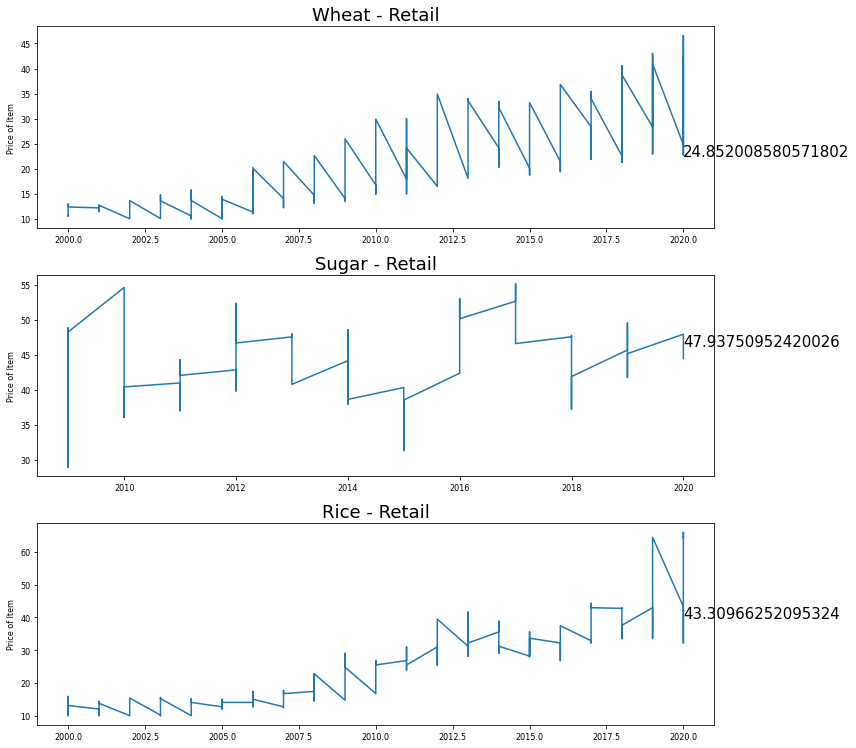

In [53]:
import matplotlib.pyplot as plt
items_list = item_specific['cm_name'].unique().tolist()
fig, ax = plt.subplots(nrows=len(items_list), figsize=(12,len(items_list)*3.5)) #dynamically set the figure size from the number of subplots. I find that 3.5 is a good height per subplot to see the data

for i in items_list:
    ind = items_list.index(i) #a trick to get a list of 0 to whatever 
    filt = item_specific['cm_name'] == i #filter the dataframe for each item in the list
    
    ax[ind].plot(item_specific.loc[filt]['mp_year'],item_specific.loc[filt]['currency_product']) #plotting the filtered dataframe. The brackets make the axis variable dynamic
    ax[ind].set_title(i, size=18) #here I am setting the title of each subplot to be the category
    ax[ind].set_ylabel('Price of Item', size=8) #setting the ylabel and font size
    ax[ind].xaxis.set_tick_params(labelsize=8) #setting the font size of the x axis
    ax[ind].yaxis.set_tick_params(labelsize=8) #setting the font size of the y axis
    
    #Optionally add data labels or text to the subplots
    cases_yesterday_filter = (item_specific['mp_year'] == item_specific['mp_year'].max()) & (item_specific['cm_name'] == i) 
    cases_yesterday = item_specific.loc[cases_yesterday_filter].iloc[0]['currency_product'] #applying the filter to the dataframe
    ax[ind].annotate(str(cases_yesterday), xy=(item_specific['mp_year'].max(),cases_yesterday),xycoords = 'data', ha ='left', va='top', fontsize =15) #adding the datapoint to the subplot
    plt.tight_layout()

## Using Plotly

In [54]:
#countries_list_top_20 = output3['cm_name'].unique()
import matplotlib.pyplot as plt
import plotly.express as px
items_list = item_specific['cm_name'].unique().tolist()
#fig, ax = plt.subplots(nrows=len(items_list), figsize=(12,len(items_list)*3.5)) #dynamically set the figure size from the number of subplots. I find that 3.5 is a good height per subplot to see the data

for i in items_list:
    ind = items_list.index(i) #a trick to get a list of 0 to whatever 
    filt = item_specific['cm_name'] == i #filter the dataframe for each item in the list
    print(i)
    fig = px.bar(x=item_specific.loc[filt]['mp_year'], y=item_specific.loc[filt]['currency_product'], labels={'x':'Year', 'y':'Price in $'})
    fig.show()


Wheat - Retail


Sugar - Retail


Rice - Retail


# Arkouda Configuration

In [48]:
cfg=ak.get_config()

In [49]:
cfg

{'arkoudaVersion': 'v2021.08.20+18.g7a657ad',
 'ZMQVersion': '4.3.2',
 'HDF5Version': '1.12.1',
 'serverHostname': 'MacBook-Pro-7.local',
 'ServerPort': 5555,
 'numLocales': 1,
 'numPUs': 4,
 'maxTaskPar': 4,
 'physicalMemory': 8589934592,
 'distributionType': 'domain(1,int(64),false)',
 'LocaleConfigs': [{'id': 0,
   'name': 'MacBook-Pro-7.local',
   'numPUs': 4,
   'maxTaskPar': 4,
   'physicalMemory': 8589934592}],
 'authenticate': False,
 'logLevel': 'INFO',
 'byteorder': 'little'}